In [1]:
import rasterio as rio
from rasterio.plot import show
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import folium
import os
import fnmatch
from TOA_Reflectance_Stacker import histogram_stretch
from tqdm import tqdm
import earthpy.plot as ep
from rasterio.plot import reshape_as_image
from matplotlib.colors import ListedColormap

EPSG:3098


,id,LULC,geometry
0,1,Water,"MULTIPOLYGON (((620051.240 3611007.417, 618491..."
1,1,Water,"MULTIPOLYGON (((607365.246 3662050.119, 607813..."
2,1,Water,"MULTIPOLYGON (((610874.683 3637412.642, 611461..."
3,3,Forest,"MULTIPOLYGON (((614310.282 3614661.632, 614217..."
4,3,Urban,"MULTIPOLYGON (((574670.351 3638926.062, 574522..."
5,1,Water,"MULTIPOLYGON (((603811.626 3627211.855, 605685..."
6,1,Water,"MULTIPOLYGON (((608403.363 3627232.446, 609103..."
7,2,Forest,"MULTIPOLYGON (((614776.201 3630346.797, 614971..."
8,2,Forest,"MULTIPOLYGON (((616474.938 3630573.295, 616516..."
9,2,Forest,"MULTIPOLYGON (((612655.354 3626372.782, 612892..."


<Axes: >

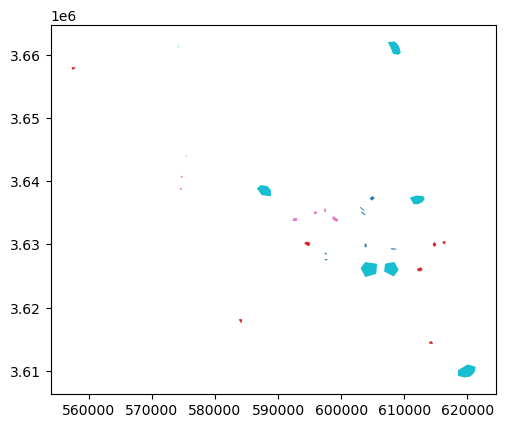

In [2]:
land_use = gpd.read_file("Supervised Land Use Updated.geojson")

print(land_use.crs)

display(land_use)

land_use.plot(column = "LULC")

In [3]:
# To prep the data for ML analysis, we need two numpy arrays:
# X: a numpy array that contains all of the band data for the pixel
# y: the labels for training
X = np.array([], dtype = np.float32).reshape(0,10) # Create an array with 7 columns and 0 rows
                                                  # we're gonna stack new pixels inside
y = np.array([], dtype = np.string_) # labels for training


with rio.open("nagasaki_toa.tif") as src:
    band_count = src.count
    
    # Iterate
    for index, row in land_use.iterrows():
        feature = [row["geometry"]]
        
        # crop the image - mask function returns a tuple
        out_image, out_transform = rio.mask.mask(src, feature, crop = True)
        
        # out_image has a shape (7, height, width)
        
        # Since this returns a rectangular array, and our shape is not rectangular, there will be
        # a bunch of nans - get rid of them.
        
        # note that this gets rid of any column that has ANY nans
        # The following code returns a row for each band, with each column representing a pixel
        out_image_trimmed = out_image[:, ~np.any(np.isnan(out_image), axis = 0)]
        
        # We actually want this the other way around - we want a row for pixel, and a column for each
        # band - so we transpose the image
        out_image_trimmed = out_image_trimmed.T
        
        # We append the labels to the answer array equal to the number of pixels:
        # Remember to put brackets around the row["LULC"], or else you'll get "forestforestforest"
        y = np.append(y, [row["LULC"]] * out_image_trimmed.shape[0])
        
        # vstack is like concat for rows. Note that to vstack correctly, the array tuple that you feed
        # to vstack must have the same column dimension
        X = np.vstack((X, out_image_trimmed))

src.close()

In [4]:
### Check if it worked correctly: Two arrays should have the same number of rows/columns
print(X.shape)
print(y.shape)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

(26423, 10)
(26423,)


Text(0.5, 1.0, 'Band Intensities Higher Ref Subset')

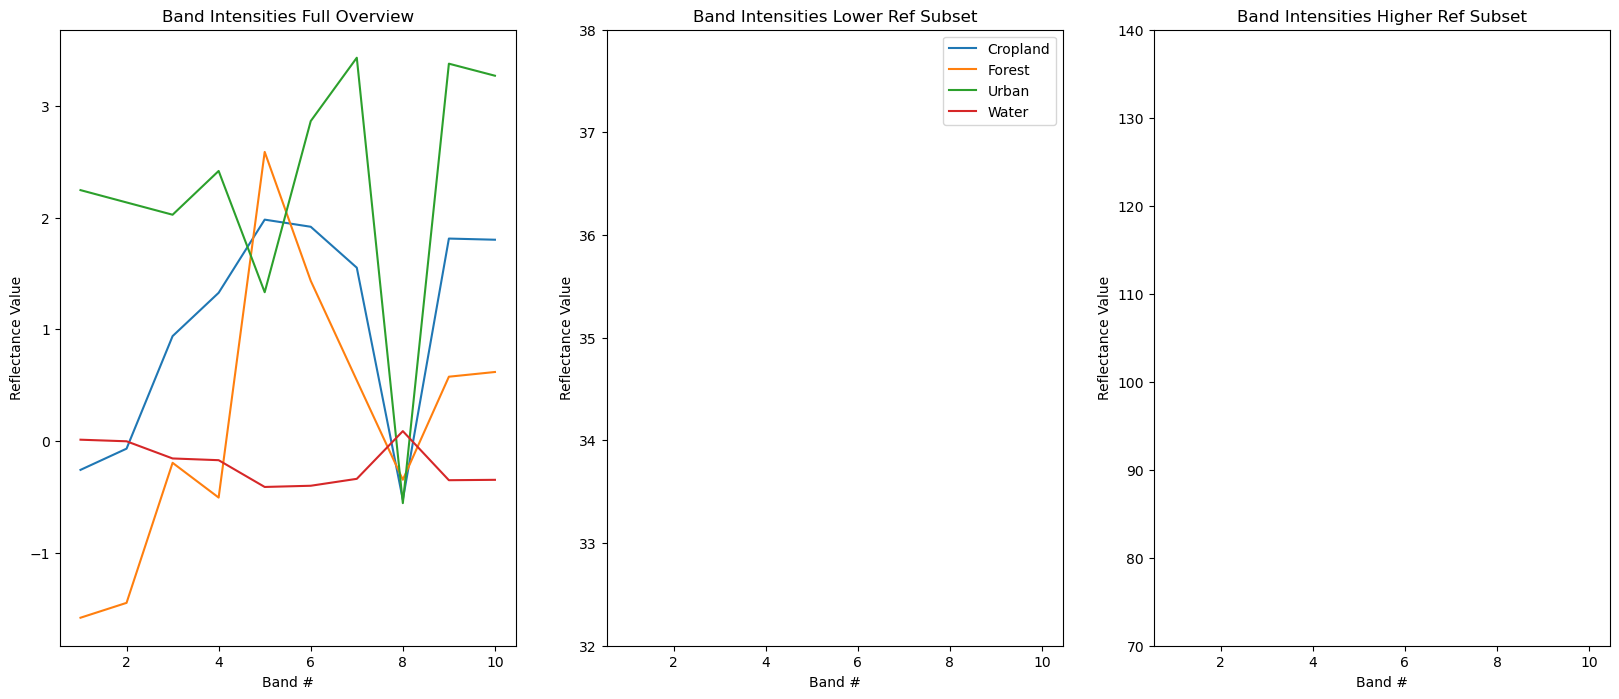

In [5]:
## Note that this plots 3 graphs
# modify the ylim of graphs ax[1] and ax[2] if you need to look at different reflectance ranges

fig, ax = plt.subplots(1,3, figsize=[20,8])

# numbers 1-7
band_count = np.arange(1,11)

classes = np.unique(y)
for class_type in classes:
    band_intensity = np.mean(X[y==class_type, :], axis=0)
    ax[0].plot(band_count, band_intensity, label=class_type)
    ax[1].plot(band_count, band_intensity, label=class_type)
    ax[2].plot(band_count, band_intensity, label=class_type)
# plot them as lines

# Add some axis labels
ax[0].set_xlabel('Band #')
ax[0].set_ylabel('Reflectance Value')
ax[1].set_ylabel('Reflectance Value')
ax[1].set_xlabel('Band #')
ax[2].set_ylabel('Reflectance Value')
ax[2].set_xlabel('Band #')
#ax[0].set_ylim(32,38)
ax[1].set_ylim(32,38)
ax[2].set_ylim(70,140)
#ax.set
ax[1].legend(loc="upper right")
# Add a title
ax[0].set_title('Band Intensities Full Overview')
ax[1].set_title('Band Intensities Lower Ref Subset')
ax[2].set_title('Band Intensities Higher Ref Subset')

# We can see that for our data, cropland and forest may be difficult to distinguish

In [6]:
from sklearn.naive_bayes import GaussianNB

# This one has no hyperparameters
gnb = GaussianNB()
gnb.fit(X, y)

GaussianNB()

In [11]:
# our classifier is now trained.
# What we need to do now is use our classifier on the full image and see what the entire map looks 
# like
src = rio.open("nagasaki_toa.tif")
dataset = src.read()
# Create a TCC for comparison
tcc = histogram_stretch(src.read([4,3,2]), 0)
src.close()

# Reshape our image into rows of pixels and columns of bands
testset = dataset.swapaxes(0,2).reshape(-1, 10)

# if you used a scaler, remember to transform it!
testset = scaler.transform(testset)

# Get the classified data
nagasaki_classified = gnb.predict(testset) # Use fit_predict to train on data

# Reshape back into 2D image
# NOTE the order of the reshape matters because we swapped axes
# We must reshape width,height, then transpose
nagasaki_reshaped = nagasaki_classified.reshape(dataset.shape[2], dataset.shape[1]).T

In [12]:
# Use this to transform our nagasaki_reshaped (which has a bunch fo string labels) into integers

lulc_dict = dict((
    ("Urban", 0),
    ("Cropland", 1),
    ("Forest", 2),
    ("Water", 3),
    ("Bare Land", 4),
))

# Invert dictionary
inv_dict = {v: k for k, v in lulc_dict.items()}

# apparently faster - returns unique values as well as the indices that can be used to reconstruct
# the array
u, inv = np.unique(nagasaki_reshaped, return_inverse = True)
nagasaki_reshaped = np.array([lulc_dict[x] for x in u])[inv].reshape(nagasaki_reshaped.shape)

# def str_class_to_int(class_array):
#     class_array[class_array == 'Urban'] = 0
#     class_array[class_array == 'Cropland'] = 1
#     class_array[class_array == 'Forest'] = 2
#     class_array[class_array == 'Water'] = 3
#     class_array[class_array == 'Bare Land'] = 4
#     return(class_array.astype(int))

# nagasaki_reshaped = str_class_to_int(nagasaki_reshaped)

In [19]:


# Set up dictionary for color map
colors = dict((
    (0, "grey"),   # Urban 
    (1, "xkcd:lime green"),      # Cropland 
    (2, "green"),    # Forest 
    (3, "blue")   # Water 
#     (4, "xkcd:brown")
))

cmap = ListedColormap([colors[key] for key in colors], name = "LULC")

In [20]:
%matplotlib qt5

fig, ax = plt.subplots(1,2,figsize = (20,10))

ax[0].imshow(rio.plot.reshape_as_image(tcc))
kmeans = ax[1].imshow(nagasaki_reshaped, cmap = cmap, interpolation='nearest')
ep.draw_legend(im_ax = kmeans, titles = [inv_dict[key] for key in np.unique(nagasaki_reshaped)], cmap = cmap)


In [ ]:
### POST-MORTEM ###
# The results are QUITE shit - in particular, some of the sandy water was misidentified as cropland, 
# resulting in some really shit classifications. Some urban areas were also misclassified as cropland
# as well - in general, cropland appears to be the issue. The water areas with cloud are also a problem.


In [19]:
for index, row in land_use.iterrows():
    print(type(row["geometry"]))

<class 'shapely.geometry.multipolygon.MultiPolygon'>
<class 'shapely.geometry.multipolygon.MultiPolygon'>
<class 'shapely.geometry.multipolygon.MultiPolygon'>
<class 'shapely.geometry.multipolygon.MultiPolygon'>
<class 'shapely.geometry.multipolygon.MultiPolygon'>
<class 'shapely.geometry.multipolygon.MultiPolygon'>
<class 'shapely.geometry.multipolygon.MultiPolygon'>
<class 'shapely.geometry.multipolygon.MultiPolygon'>
<class 'shapely.geometry.multipolygon.MultiPolygon'>
<class 'shapely.geometry.multipolygon.MultiPolygon'>
<class 'shapely.geometry.multipolygon.MultiPolygon'>
<class 'shapely.geometry.multipolygon.MultiPolygon'>
<class 'shapely.geometry.multipolygon.MultiPolygon'>
<class 'shapely.geometry.multipolygon.MultiPolygon'>
<class 'shapely.geometry.multipolygon.MultiPolygon'>
<class 'shapely.geometry.multipolygon.MultiPolygon'>
<class 'shapely.geometry.multipolygon.MultiPolygon'>


In [86]:
### A bit of testing and making sure it works in theory

test_feature = land_use.iloc[3]["geometry"]
print(land_use.iloc[3]["LULC"])

full_dataset = rio.open("nagasaki_toa.tif")

# tcc_subset = full_dataset.read([4,3,2])
tcc = histogram_stretch(full_dataset.read([4,3,2]), 0)

# Note that the mask function does not work on numpy arrays - it requires a "read" object from
# rio. Thus, if you want to do any pre-processing, you'll have to do it first THEN write to raster
# then read into mask.mask

# Note that mask needs an iterable of geometries
cropped, cropped_transform = rio.mask.mask(tcc, [test_feature], crop = True)

# Note that this stuff looks a bit wonky because the data was stretched to the min/max of the 
# cropped raster - i.e., small differences are significantly amplified
# test = histogram_stretch(cropped, 0)

fig, ax = plt.subplots()
# ax.imshow(reshape_as_image(test))
show(cropped)

Forest


AttributeError: 'numpy.ndarray' object has no attribute 'nodata'

<Axes: >

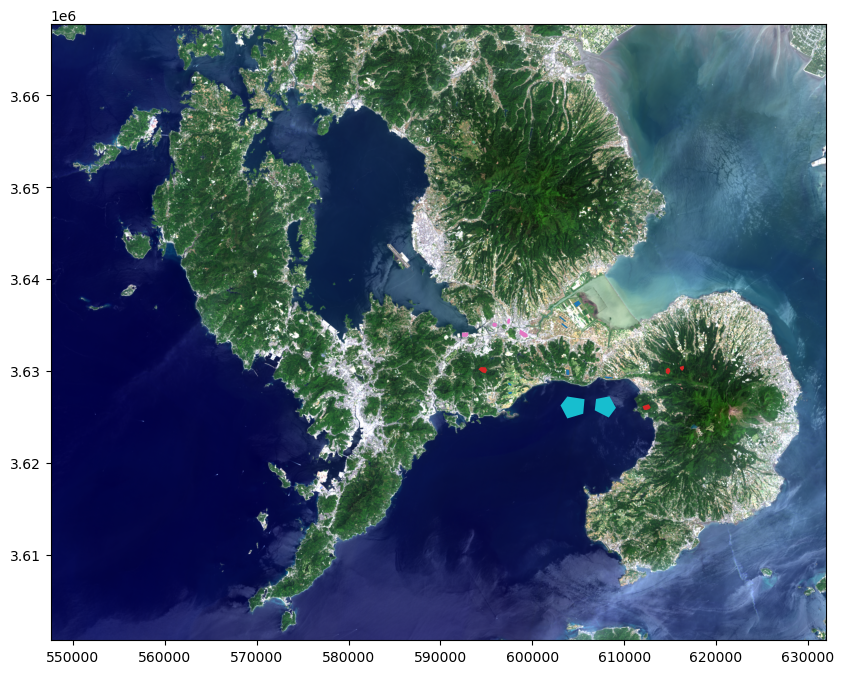

In [81]:
tcc = histogram_stretch(full_dataset.read([4,3,2]), 0)

fig, ax = plt.subplots(figsize = (12, 8))
show(tcc, ax = ax, transform = full_dataset.transform)
land_use.plot(ax = ax, column = "LULC")

In [106]:
test = np.arange(24).reshape(3,2,4).astype(np.float32)

# seed a nan
test[2,1,3] = np.nan

test

array([[[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.]],

       [[ 8.,  9., 10., 11.],
        [12., 13., 14., 15.]],

       [[16., 17., 18., 19.],
        [20., 21., 22., nan]]], dtype=float32)

In [121]:
correct = test[:, ~np.any(np.isnan(test), axis = 0)].T

correct

array([[ 0.,  8., 16.],
       [ 1.,  9., 17.],
       [ 2., 10., 18.],
       [ 3., 11., 19.],
       [ 4., 12., 20.],
       [ 5., 13., 21.],
       [ 6., 14., 22.]], dtype=float32)

In [125]:
# a = np.array([]).reshape(0,3)
a = np.vstack((a, correct))
a

array([[ 0.,  8., 16.],
       [ 1.,  9., 17.],
       [ 2., 10., 18.],
       [ 3., 11., 19.],
       [ 4., 12., 20.],
       [ 5., 13., 21.],
       [ 6., 14., 22.],
       [ 0.,  8., 16.],
       [ 1.,  9., 17.],
       [ 2., 10., 18.],
       [ 3., 11., 19.],
       [ 4., 12., 20.],
       [ 5., 13., 21.],
       [ 6., 14., 22.]])